<a href="https://colab.research.google.com/github/shindejayesh987/Neural-Networks-Zero-to-Hero-By-Andrej-Karpathy/blob/main/bn_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# 1- Starter Code (from previous part)

In [ ]:
words = open("/content/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [ ]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
block_size = 3
def build_dataset(words):

  X, Y = [], []

  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden, vocab_size),generator=g)
b2 = torch.randn(vocab_size,generator=g)


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

    # batch
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1)) # flatten
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # cross-entropy loss

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i} / {max_steps}: {loss.item()}")

    lossi.append(loss.item())
    break

0 / 200000: 27.881732940673828


In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1)) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 25.167741775512695
dev loss: 25.140993118286133


In [ ]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)

    print("".join(itos[i] for i in out))


rrnhodydiediddxshvyicbesrrmhokwdnshxjyrhguyozvwuhjryhcyysewgmtiofvwths

hvcyhguyozvwthslkdaadjdyhdyrzgthxjyrhgtfxjkcynsrqhs
rrnhvqbgsexjkcynsrqhs



rrnhvvyhcyyshvyyhadiddxshvyycbyhidigdyxzvkhhjktixjyrnnxvymhjryhcyysovyyhjkdixjyrnnxvymhjzigdyxzvkhhdirzoahodydzkyojvwhmdtbewidigdyxzvkhhjkyixfkcovwthslrindiodhshwjwtesjrhgcbthrfwtksjnhguyozvyyhjhrnrzccvwucovwixtyxfvwamsbreshwjwyhshfyyrzgthxjyrnnxvymhjkdokhdnejkhgkbdnrzucovwthslrhcgfccyhguyozvwthslkdaadjdyhddrzvwucovwthslrfucovwixfkcovwthsjkhgkbdnrzccvnhguyozvwthsewgmtiofvwovsvcvvyhvkrhndrewaesyxshvyycoes
hlcbyhidigdyxzvkhhjkdoewiekkouhozwidtesjrhgubdxshvyyhjkdokhdnguhddrzvwthslrjnhguyozvwthslrhcgfccamhjzigkyojvwhmdtbejrrhshojyhguyozvwthslrhcgfccamhjzigkyojyhguyozvwucovwthslkdaadjdyhddrzvwths

rrnhodydiejoyhshwjkhgkbdnrzoahodydiejoyhshwjwthslrhcgfccamhjziyoadiddxshvyycoes
rrnhvqbgcewaesyxshvyyhddrzvwths

hvcyhguyozvwuhjryhcyysewgmtiofvwthslrhcgfccyhguyozvwthslrhcgfy
rrnhodydiddadiddadiddadiddxshvyyhouyhodydiddadiddadiddxshvyyhjkdokhdnejkyix

# 2- Fixing the Initialization
we expect similar probability for each character = 1 / 27

In [ ]:
expected_loss = - torch.tensor(1 / 27).log()
print(expected_loss)

tensor(3.2958)


In [ ]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

11897


In [ ]:
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten
hpreact = embcat @ W1 + b1 # hidden layer pre-activation
h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")


initial loss = 3.32205867767334


# 3- Fixing the saturated tanh
h has many values = 1 or -1, so the gradient is 0

## 3.1 - Explaining The Problem

Text(0.5, 1.0, 'tanh')

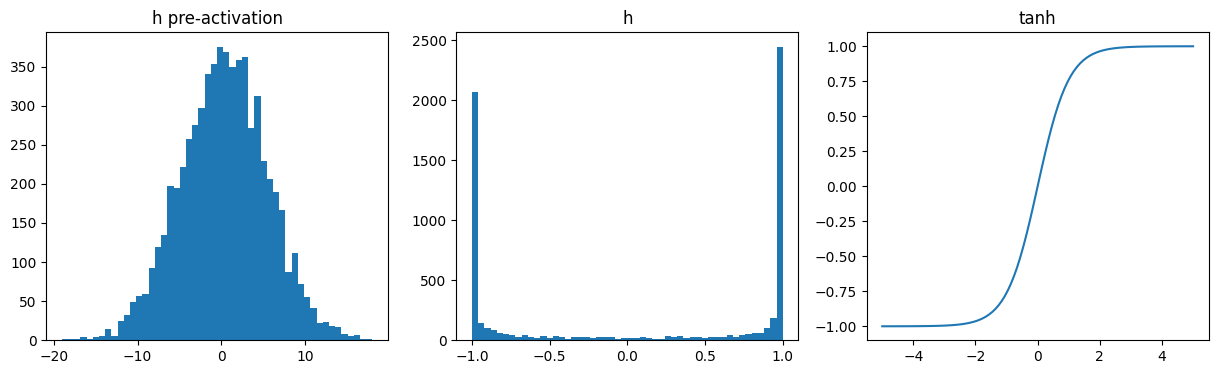

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))


axes[0].hist(hpreact.flatten().data, bins = 50);
axes[0].set_title("h pre-activation")

axes[1].hist(h.flatten().data, bins = 50);
axes[1].set_title("h")

axes[2].plot(torch.linspace(-5, 5, 100), torch.tanh(torch.linspace(-5, 5, 100)));
axes[2].set_title("tanh")

comment: There're many `values = 1 or -1` in tanh because pre-activations with extreme values

➡️ changing the input doesn't change the outputvalue much

➡️ the derivative of tanh is `1 - tanh^2`

➡️ the gradient is 0 for `all values = 1 or -1`

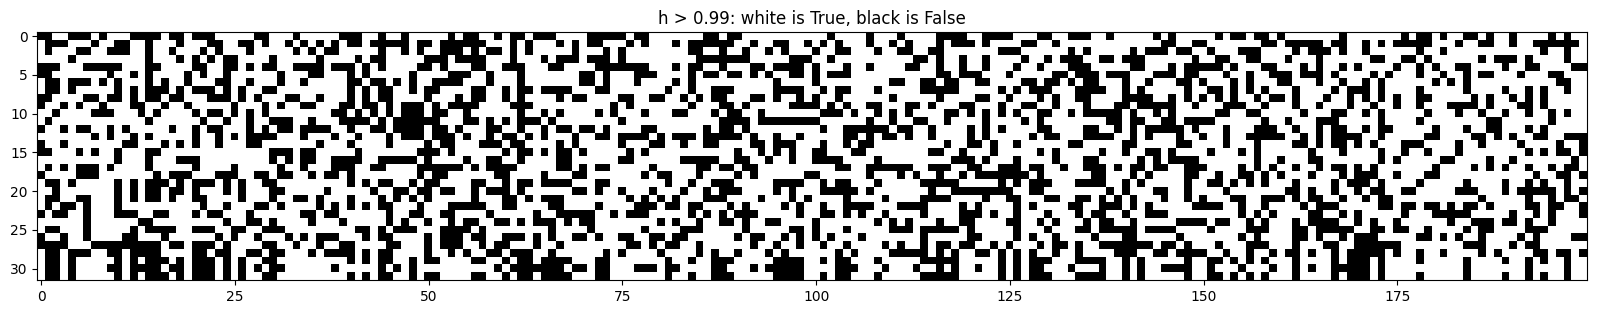

In [ ]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation='nearest')
plt.title("h > 0.99: white is True, black is False");

comment: if a column is completely white, it's a dead neuron

## 3.2- Solution
multiply W1, b1 by a small number

In [ ]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

11897


In [ ]:
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten
hpreact = embcat @ W1 + b1 # hidden layer pre-activation
h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")


initial loss = 3.3134593963623047


Text(0.5, 1.0, 'tanh')

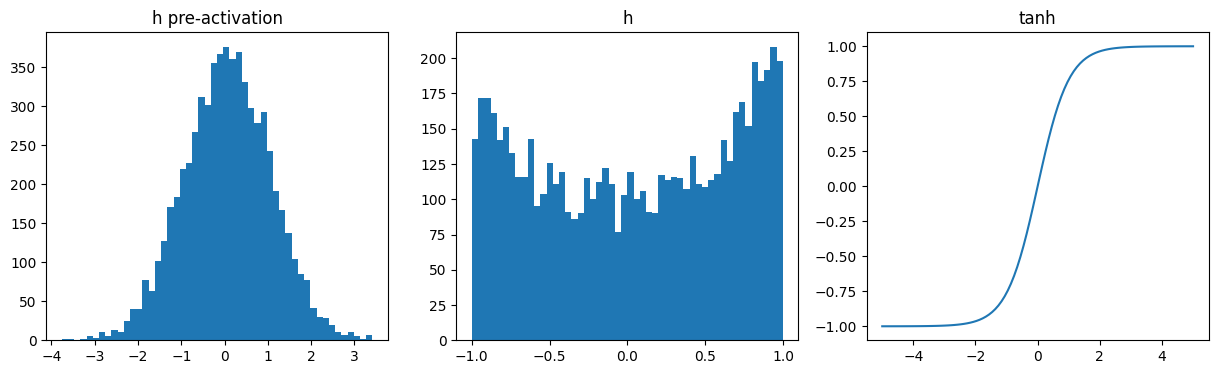

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))


axes[0].hist(hpreact.flatten().data, bins = 50);
axes[0].set_title("h pre-activation")

axes[1].hist(h.flatten().data, bins = 50);
axes[1].set_title("h")

axes[2].plot(torch.linspace(-5, 5, 100), torch.tanh(torch.linspace(-5, 5, 100)));
axes[2].set_title("tanh")

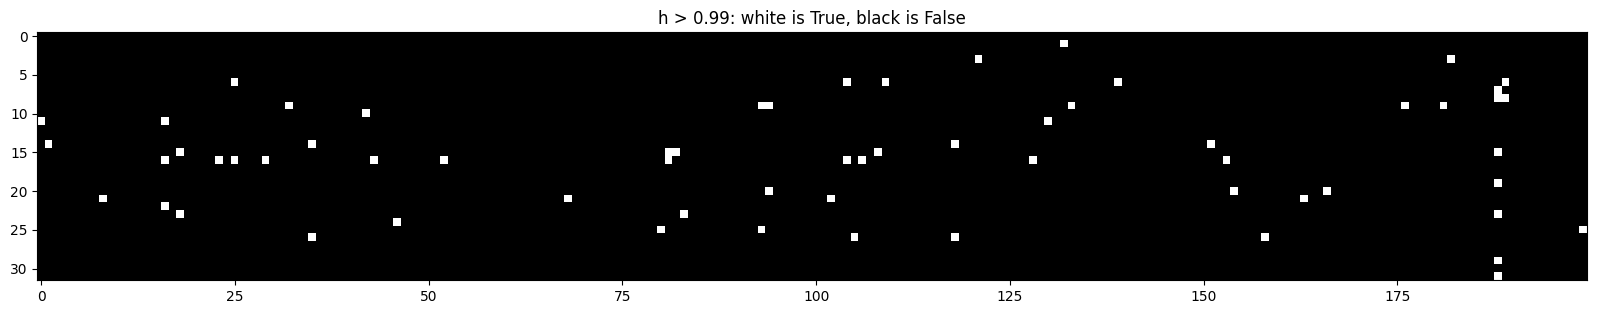

In [ ]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation='nearest')
plt.title("h > 0.99: white is True, black is False");

# 4- Calculating the Init Scale: Kaiming Initialization
where did the numbers (0.01, 0.1, 0.2) come from in initializing the weights and biases?

x mean = -0.008, std = 1.003
y mean = -0.009, std = 3.089
y scaled mean = -0.003, std = 0.977


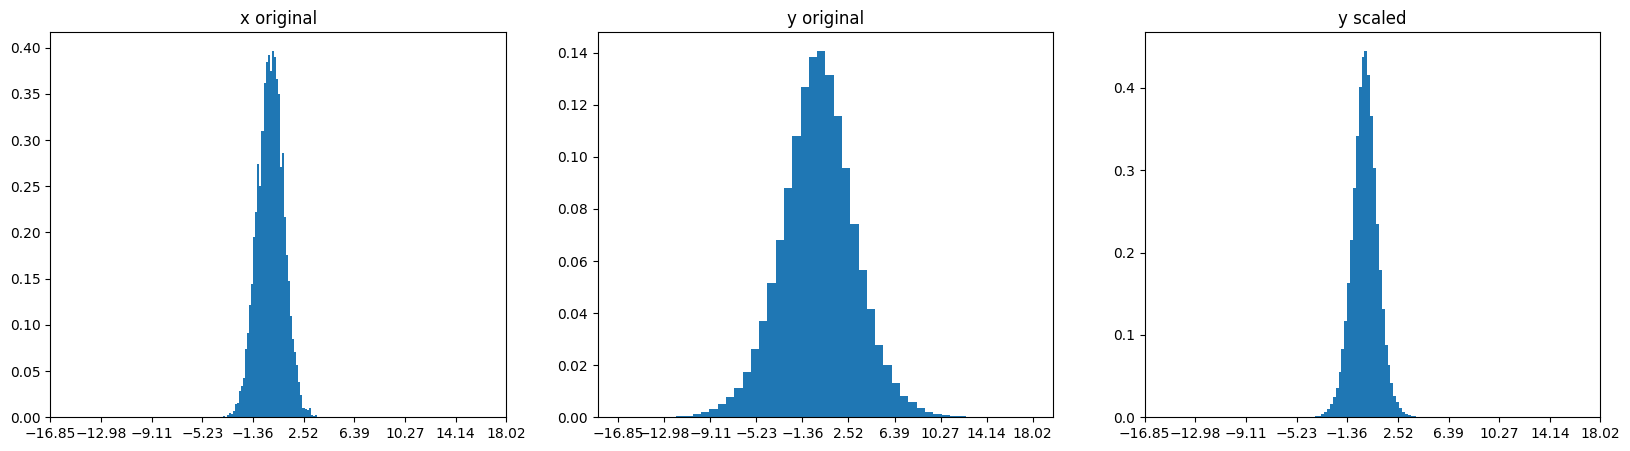

In [ ]:
# 1000 training examples, 10 features
x = torch.randn(1000,10)

# 10 features, 200 neurons
w = torch.randn(10, 200)

# pre-activation
y = x @ w

print(f"x mean = {x.mean():.3f}, std = {x.std():.3f}")
print(f"y mean = {y.mean():.3f}, std = {y.std():.3f}")

fig, axes = plt.subplots(1, 3, figsize = (20, 5))

axes[0].hist(x.flatten().data, bins = 50, density = True)
axes[0].set_xticks(torch.linspace(y.min(), y.max(), 10))
axes[0].set_title("x original")


axes[1].hist(y.flatten().data, bins = 50, density = True)
axes[1].set_xticks(torch.linspace(y.min(), y.max(), 10))
axes[1].set_title("y original");

# scale the weights by Kaiming Initialization: dividing by sqrt(fan_in) = sqrt(10) in this case
w_scaled = w /  math.sqrt(w.shape[0])
y_scaled = x @ w_scaled

axes[2].hist(y_scaled.flatten().data, bins = 50, density = True)
axes[2].set_xticks(torch.linspace(y.min(), y.max(), 10))
axes[2].set_title("y scaled");

print(f"y scaled mean = {y_scaled.mean():.3f}, std = {y_scaled.std():.3f}")

# 5- Batch Normalization
we want to make pre-activations not extreme, but roughly a gaussian distribution (mean = 0, std = 1)

## 5.1- Explaination

In [ ]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12297


In [ ]:
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten

hpreact = embcat @ W1 + b1 # hidden layer pre-activation

# normalize the batch ➡️ unit gaussian
hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / (hpreact.std(dim=0, keepdim=True) + 1e-6)

# we want it to be gaussian only at initialization (not always), the Neural Network may need to change the it
# Scale and Shift: scale the normalized batch by a learnable parameter (gamma) and shift it by another learnable parameter (beta)
hpreact = hpreact * bngain + bnbias

h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")


initial loss = 3.3146886825561523


## 5.2- Sampling

how to forward a single example to the model and get a prediction, even the model uses the mean ans std of the batch to normalize the input

we need a step after training, and find the mean and std of the whole training set


In [ ]:
# Calibrate the batch norm statistics
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view((emb.shape[0], -1))
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1)) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)

    # batch norm in test mode
    hpreact = (hpreact - bnmean) / (bnstd + 1e-6)
    hpreact = hpreact * bngain + bnbias


    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 3.3056492805480957
dev loss: 3.305365800857544


### 5.2.1- it can be done during training (without additional step)

In [ ]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# mean and std buffers, (not trainable)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12297


In [ ]:
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten

hpreact = embcat @ W1 + b1 # hidden layer pre-activation

# normalize the batch ➡️ unit gaussian
bnmeani = hpreact.mean(dim=0, keepdim=True)
bnstdi = hpreact.std(dim=0, keepdim=True)

hpreact = (hpreact - bnmeani) / (bnstdi + 1e-6)

# updating outside (and on the side) of the gradient based optimization
with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

# we want it to be gaussian only at initialization (not always), the Neural Network may need to change the it
# Scale and Shift: scale the normalized batch by a learnable parameter (gamma) and shift it by another learnable parameter (beta)
hpreact = hpreact * bngain + bnbias

h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")


initial loss = 3.3146886825561523


`bnmean_running` should equal to `bnmean` after training, same for `bnstd_running` and `bnstd`

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1)) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)

    # batch norm in test mode
    hpreact = (hpreact - bnmean_running) / (bnstd_running + 1e-6)
    hpreact = hpreact * bngain + bnbias


    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 3.3057639598846436
dev loss: 3.3057150840759277


## 5.3- Remove the bias
the bias is now useless: since we subtract the mean, the bias is subtracted too ➡️ b1.grad must be zero now

the batch normalization bias `bnbias` is responsible for biasing the the distribution

# 6- PyTorch-ifying the model

In [ ]:
# visualization parameters (play with these)
gain = 0.2
last_layer_confidence = 0.1

using_batch_norm = True
div_by_fan_in = True

In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)
        if div_by_fan_in:
            self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),       generator = g)

if not using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, vocab_size)
    ]
if using_batch_norm:
    layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size) # you can add it here too
    ]



with torch.no_grad():
    # last layer: make less confident
    if not using_batch_norm:
        layers[-1].weight *= last_layer_confidence
    if using_batch_norm:
        layers[-1].gamma *= last_layer_confidence

    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # change this gain (default 5/3)
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    x = emb.view((emb.shape[0], -1)) # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())

    # update to data ratio: How great is the update compared to the data itself?
    with torch.no_grad():
        update_to_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters if p.grad is not None])

    if i >= 1000:
        break

step 0 loss 3.287036418914795


# 7- Visualizations

## 7.1- Forward Pass Activations stats

layer 2 mean -0.00 std 0.64 saturated 2.56%
layer 5 mean 0.00 std 0.66 saturated 2.00%
layer 8 mean 0.00 std 0.66 saturated 1.47%
layer 11 mean 0.00 std 0.66 saturated 1.22%
layer 14 mean -0.00 std 0.66 saturated 0.72%


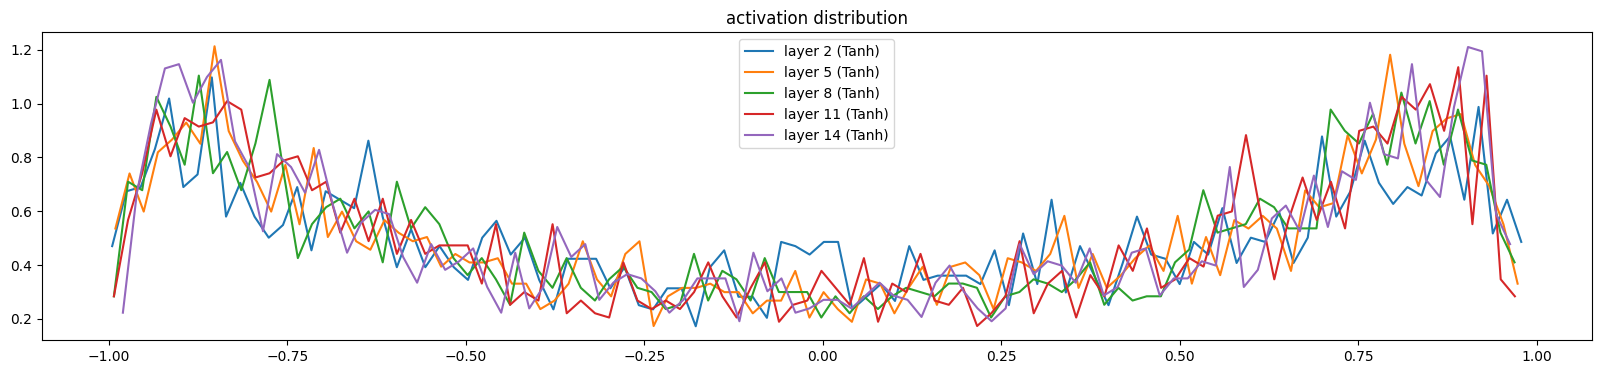

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} mean {t.mean().item():.2f} std {t.std().item():.2f} saturated {((t.abs() > 0.97).float().mean().item()) * 100:.2f}%")

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("activation distribution")
plt.show()

## 7.2- Backward pass Gradient Statistics

layer 2 mean -0.00000 std 0.00125 saturated 0.00000000%
layer 5 mean -0.00000 std 0.00110 saturated 0.00000000%
layer 8 mean 0.00000 std 0.00095 saturated 0.00000000%
layer 11 mean 0.00000 std 0.00094 saturated 0.00000000%
layer 14 mean 0.00000 std 0.00105 saturated 0.00000000%


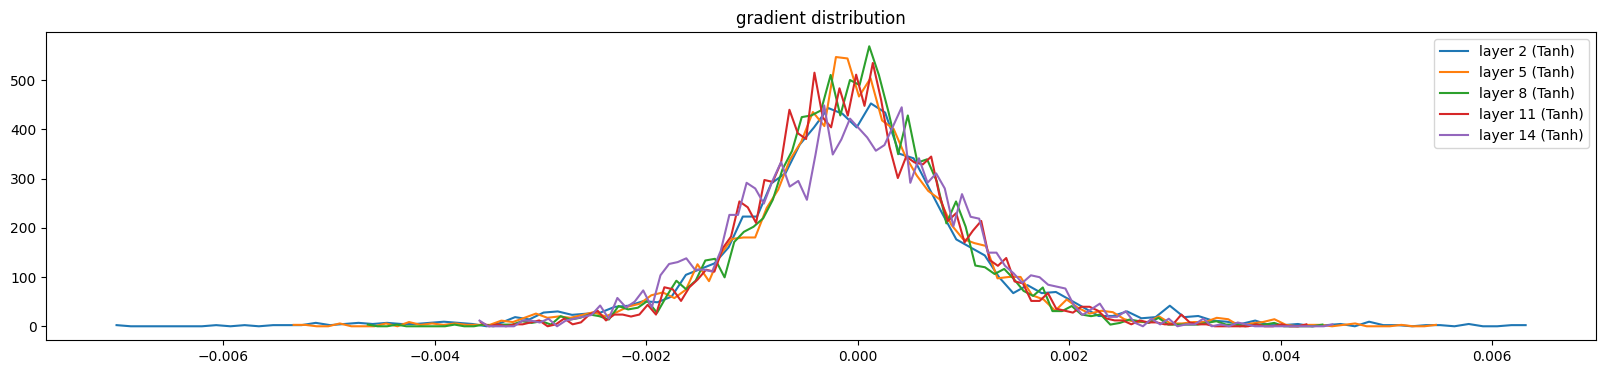

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} mean {t.mean().item():.5f} std {t.std().item():.5f} saturated {((t.abs() > 0.97).float().mean().item()) * 100:.8f}%")

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("gradient distribution")
plt.show()

comment: Gradients are not vanishing or exploding

## 7.3- Parameter Activation and Gradient Statistics

weight shape (27, 10) | mean -0.00000 | std 0.00737 | grad:data ratio 7.37e-03
weight shape (30, 100) | mean 0.00031 | std 0.01392 | grad:data ratio 2.29e-01
weight shape (100, 100) | mean 0.00003 | std 0.00601 | grad:data ratio 2.01e-01
weight shape (100, 100) | mean -0.00002 | std 0.00522 | grad:data ratio 1.91e-01
weight shape (100, 100) | mean -0.00005 | std 0.00506 | grad:data ratio 1.92e-01
weight shape (100, 100) | mean -0.00011 | std 0.00522 | grad:data ratio 2.00e-01
weight shape (100, 27) | mean 0.00002 | std 0.01235 | grad:data ratio 2.86e-01


Text(0.5, 1.0, 'Weights Gradient distribution')

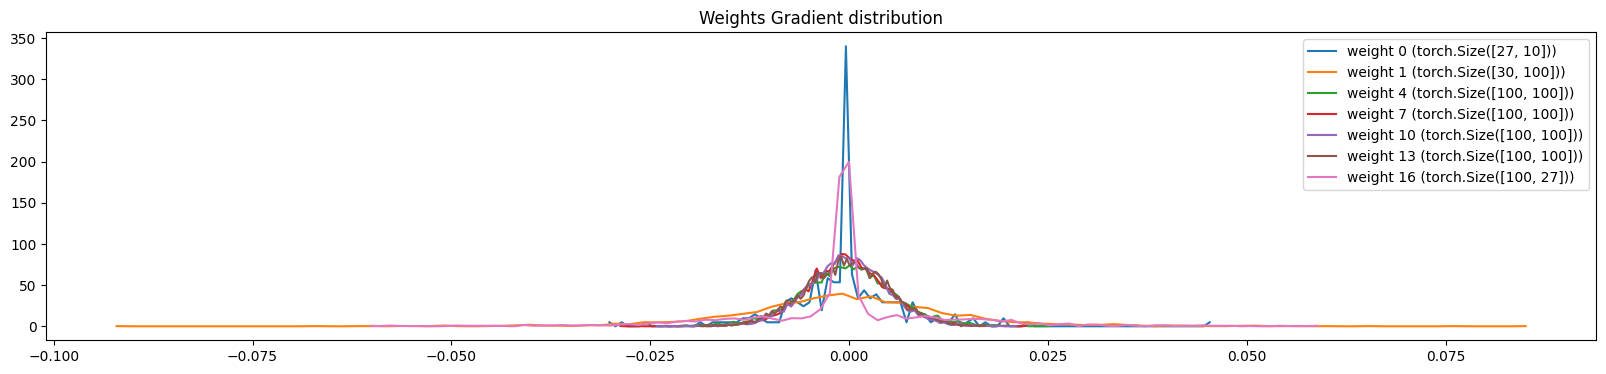

In [ ]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    t = p.grad
    # neglect bias and batch norm parameters (weights only)
    if p.ndim == 2:
        print(f"weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"weight {i} ({p.shape})")

plt.legend(legends)
plt.title("Weights Gradient distribution")

## 7.4- update: data raito over time

Text(0.5, 1.0, 'Update to Data ratio')

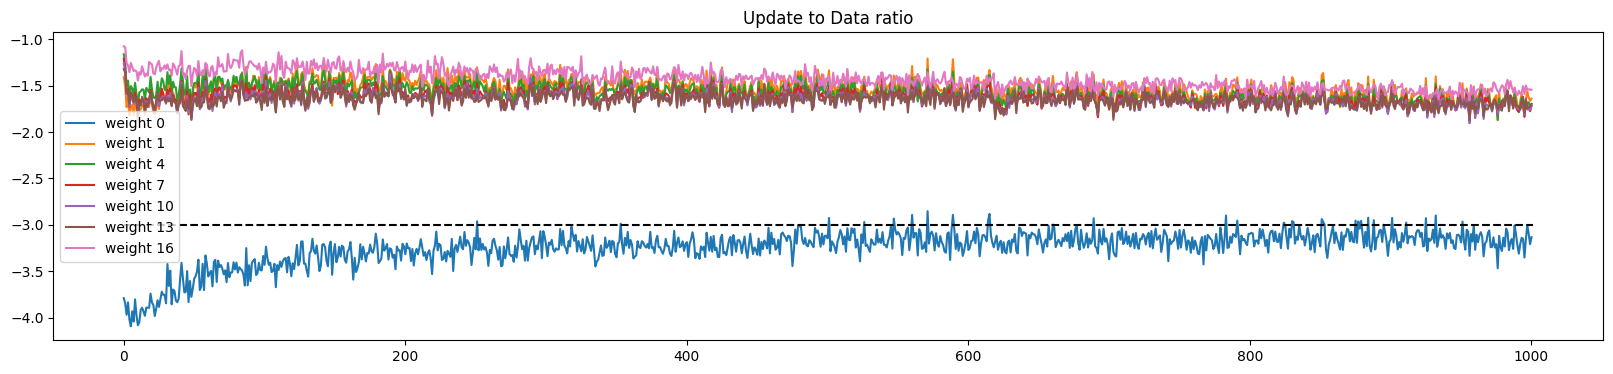

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p
    # neglect bias and batch norm parameters (weights only)
    if p.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append(f"weight {i}")

# rough guide for what it should be: 1e-3
plt.plot([0, len(update_to_data_ratio)], [-3, -3], color="black", linestyle="--")
plt.legend(legends)
plt.title("Update to Data ratio")

comments:
- changing the gain (when using batchnorm) doesn't change too much except the Update to Data Ratio
- removing fan_it doesn't change much too (when using batchnorm)

conclusion: batchnorm makes the model more robust